In [1]:
import glob
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

We aim to investigate the relationship between trajectory length, swing speed, pitch speed, pitch spin, hit speed, contact point on the bat, level of stress, and exit velocity's conversion rate. We initially tested both regression models (to predict the exact value of exit velocity's conversion rate) and classification models (to categorize the conversion rate into one of six bins labeled 0-5: [0, 0.5), [0.5, 0.6), [0.6, 0.7), [0.7, 0.8), [0.8, 1)). Based on performance metrics, we chose the classification model as it provided better results. We selected Random Forest as our robust model because it effectively handles non-linear relationships and is resistant to outliers.

Input x:
- trajectory length for sample bat's
- swing speed
- pitch speed
- pitch spin
- Hit speed
- contact point on the bat
- level of stress

Output y:
- exit velocity's conversion rate: calculated exit velocity/theoretical exit velocity


In [2]:
# Define the path to your JSONL files
path = 'dataset/*.jsonl'  # Adjust the path accordingly

# Use glob to get all the file names
all_files = glob.glob(path)

# Create an empty list to store DataFrames
df_list = []

# Iterate through each file and load it into a DataFrame
for file in all_files:
    df = pd.read_json(file, lines=True)
    df_list.append(df)

# Concatenate all DataFrames into a single DataFrame
full_df = pd.concat(df_list, ignore_index=True)
full_df

,units,summary_acts,summary_score,events,samples_ball,samples_bat
0,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '54e48da8-67a0-46a4-bf51...,"{'runs': {'game': {'team1': 2, 'team2': 0}, 'i...",[],"[{'time': 0.0206462, 'pos': [-2.78340062072433...",[{'event': 'No'}]
1,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': 'f1c5834c-ba80-419b-883f...,"{'runs': {'game': {'team1': 9, 'team2': 0}, 'i...",[],"[{'time': 0.00387, 'pos': [-3.019401849888825,...","[{'event': 'First', 'time': -0.409264099999999..."
2,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': 'ac29b4ab-63bc-4672-a29c...,"{'runs': {'game': {'team1': 9, 'team2': 0}, 'i...","[{'start': {'angle': [27.482588965436427, 65.8...","[{'time': 0.0069402, 'pos': [-2.59684931578240...","[{'event': 'First', 'time': -0.3827868, 'head'..."
3,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '8efde6c7-6ab0-40aa-a197...,"{'runs': {'game': {'team1': 0, 'team2': 0}, 'i...","[{'start': {'angle': [37.20027897884712, -9.14...","[{'time': 0.022691799999999998, 'pos': [-2.268...","[{'event': 'First', 'time': -0.4404741, 'head'..."
4,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': 'b4727ec0-5df2-48ae-baab...,"{'runs': {'game': {'team1': 0, 'team2': 0}, 'i...",[],"[{'time': 0.0197676, 'pos': [-3.41602776535463...","[{'event': 'First', 'time': -0.3568664, 'head'..."
...,...,...,...,...,...,...
1249,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': 'b111416f-6dee-423d-a6e1...,"{'runs': {'game': {'team1': 5, 'team2': 8}, 'i...",[],"[{'time': 0.006611499999999999, 'pos': [-1.618...",[{'event': 'No'}]
1250,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '40aec546-f545-4d62-b0f5...,"{'runs': {'game': {'team1': 7, 'team2': 8}, 'i...",[],"[{'time': 0.0193014, 'pos': [1.375315746956785...","[{'event': 'First', 'time': -0.3575337, 'head'..."
1251,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '4d7f6ede-fbcc-4503-b2b9...,"{'runs': {'game': {'team1': 0, 'team2': 0}, 'i...",[],"[{'time': 0.0425488, 'pos': [-1.27768825861938...",[{'event': 'No'}]
1252,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': 'accadcf0-83f6-44bd-af05...,"{'runs': {'game': {'team1': 2, 'team2': 5}, 'i...",[],"[{'time': 0.0223181, 'pos': [1.02069631103377,...",[{'event': 'No'}]


In [3]:
# Function to check if 'hit' eventId is not empty in summary_acts
def check_hit_event(summary_acts):
    if 'hit' in summary_acts and summary_acts['hit'].get('eventId'):
        return True
    return False

# Filter the dataframe
hit_df = full_df[full_df['summary_acts'].apply(check_hit_event)].reset_index(drop=True)

In [4]:
hit_df

,units,summary_acts,summary_score,events,samples_ball,samples_bat
0,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': 'ac29b4ab-63bc-4672-a29c...,"{'runs': {'game': {'team1': 9, 'team2': 0}, 'i...","[{'start': {'angle': [27.482588965436427, 65.8...","[{'time': 0.0069402, 'pos': [-2.59684931578240...","[{'event': 'First', 'time': -0.3827868, 'head'..."
1,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '8efde6c7-6ab0-40aa-a197...,"{'runs': {'game': {'team1': 0, 'team2': 0}, 'i...","[{'start': {'angle': [37.20027897884712, -9.14...","[{'time': 0.022691799999999998, 'pos': [-2.268...","[{'event': 'First', 'time': -0.4404741, 'head'..."
2,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '7139315c-faea-486f-94a4...,"{'runs': {'game': {'team1': 0, 'team2': 0}, 'i...","[{'start': {'angle': [-47.134219800973646, 29....","[{'time': 0.0150759, 'pos': [-2.06284106363084...","[{'event': 'First', 'time': -0.448233, 'head':..."
3,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '444a6133-f51f-4fda-bef8...,"{'runs': {'game': {'team1': 0, 'team2': 0}, 'i...","[{'start': {'angle': [8.5673804873675, 36.1769...","[{'time': 0.041829399999999996, 'pos': [-2.092...","[{'event': 'First', 'time': -0.444780599999999..."
4,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '443da200-358b-44b9-a8c2...,"{'runs': {'game': {'team1': 0, 'team2': 0}, 'i...","[{'start': {'angle': [-78.75746105072201, -44....","[{'time': 0.0277191, 'pos': [-3.28780754191038...","[{'event': 'First', 'time': -0.3587769, 'head'..."
...,...,...,...,...,...,...
321,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '75be364f-b32a-4182-a00c...,"{'runs': {'game': {'team1': 0, 'team2': 2}, 'i...","[{'start': {'angle': [-1.583902313797851, 70.5...","[{'time': 0.029949899999999998, 'pos': [-1.298...","[{'event': 'First', 'time': -0.426735, 'head':..."
322,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': 'b727db78-a7cb-4a87-89c7...,"{'runs': {'game': {'team1': 4, 'team2': 8}, 'i...","[{'start': {'angle': [-129.76060896087745, 64....","[{'time': 0.0705705, 'pos': [-1.50634356193979...","[{'event': 'First', 'time': -0.4261485, 'head'..."
323,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '7f083536-01f1-44d2-9d20...,"{'runs': {'game': {'team1': 2, 'team2': 8}, 'i...","[{'start': {'angle': [15.014613264323188, 31.4...","[{'time': 0.0299391, 'pos': [-1.79619955089637...","[{'event': 'First', 'time': -0.4200889, 'head'..."
324,"{'length': 'foot', 'velocity': 'mph', 'acceler...",{'pitch': {'eventId': '62666b92-5d8c-47c5-94d2...,"{'runs': {'game': {'team1': 0, 'team2': 2}, 'i...","[{'start': {'angle': [22.143770461403214, 12.0...","[{'time': 0.024475, 'pos': [-1.397807372619353...","[{'event': 'First', 'time': -0.365614999999999..."


In [5]:
hit_bat_df = hit_df['samples_bat']
hit_ballbat_df = hit_df[['samples_ball', 'samples_bat']]

## Calculate trajectory length(head)

In [6]:
def euclidean_distance(pos1, pos2):
    return np.sqrt(np.sum((np.array(pos1) - np.array(pos2))**2))

def compute_trajectory_length(records):
    length = 0.0
    for i in range(len(records) - 1):
        length += euclidean_distance(records[i], records[i+1])
    return length


# Initialize a list to store results
results = []

for hit in hit_bat_df:
    positions = [record['head']['pos'] for record in hit if 'head' in record]
    total_length = compute_trajectory_length(positions)
    results.append(total_length)

# Create a DataFrame from the results
length_df = pd.DataFrame(results, columns=['Total_length'])
length_df

,Total_length
0,28.425040
1,28.917486
2,28.405855
3,30.812189
4,29.637763
...,...
321,31.832768
322,35.992953
323,32.300059
324,29.766043


## Get pitch speed, pitch spin and hit speed; Calculate swing speed

In [7]:
def extract_features(row):
    pitch_info = row['summary_acts'].get('pitch', {})
    hit_info = row['summary_acts'].get('hit', {})
    events_info = row['events']
    swing_info = row['samples_bat']

    # Access the nested speed and spin values correctly
    pitch_speed_mph = pitch_info.get('speed', {}).get('mph', 0)  # Access 'mph' inside 'speed'
    pitch_spin_rpm = pitch_info.get('spin', {}).get('rpm', 0)    # Access 'rpm' inside 'spin'
    hit_speed_mph = hit_info.get('speed', {}).get('mph', 0)        # Access 'mph' inside 'speed'

    # Calculate swing speed
    swing_speed_mph = 0
    for i in range(len(swing_info) - 1):
        if swing_info[i].get('event') == 'Hit':
            head_pos_hit = swing_info[i]['head']['pos']
            time_hit = swing_info[i]['time']

            # Find the next datapoint after 'Hit'
            head_pos_next = swing_info[i-1]['head']['pos']
            time_next = swing_info[i-1]['time']

            # Calculate the distance and time difference
            distance = euclidean_distance(head_pos_hit, head_pos_next)
            time_diff = time_hit - time_next

            # Calculate swing speed in feet per second
            swing_speed_fps = distance / time_diff if time_diff != 0 else 0

            # Convert swing speed to miles per hour
            swing_speed_mph = swing_speed_fps / 1.46667
            break

    return pd.Series({
        'Pitch_speed(mph)': pitch_speed_mph,
        'Pitch_spin(rpm)': pitch_spin_rpm,
        'Hit_speed(mph)': hit_speed_mph,
        'Swing_speed(mph)': swing_speed_mph, # miles per second
    })


hit_info_df = hit_df.apply(extract_features, axis=1)
hit_info_df

,Pitch_speed(mph),Pitch_spin(rpm),Hit_speed(mph),Swing_speed(mph)
0,83.0,2350.0,24.0,85.834271
1,96.0,2200.0,96.0,92.379931
2,97.0,2300.0,86.0,73.792553
3,97.0,2260.0,89.0,93.306284
4,79.0,2920.0,67.0,85.136732
...,...,...,...,...
321,92.0,2300.0,82.0,86.253911
322,91.0,2150.0,76.0,90.151591
323,90.0,2370.0,103.0,94.462199
324,79.0,2550.0,101.0,86.378296


## Calculate contact point on the bat

In [8]:
# Function to find the closest time in samples_ball
def find_closest_time(ball_samples, hit_time):
    times = [sample['time'] for sample in ball_samples]
    closest_time_idx = (np.abs(np.array(times) - hit_time)).argmin()
    return ball_samples[closest_time_idx]['pos']

# Iterate over each row to find the 'Hit' event and the corresponding position in samples_ball
results = []
for index, row in hit_ballbat_df.iterrows():
    bat_samples = row['samples_bat']
    ball_samples = row['samples_ball']

    # Find the 'Hit' event in samples_bat
    hit_event = next((event for event in bat_samples if event.get('event') == 'Hit'), None)

    if hit_event:
        hit_time = hit_event['time']
        head_pos = hit_event['head']['pos']
        handle_pos = hit_event['handle']['pos']

        # Find the closest time in samples_ball
        closest_ball_pos = find_closest_time(ball_samples, hit_time)

                # Calculate the distance from ball position to head position
        distance_ball_to_head = euclidean_distance(closest_ball_pos, head_pos)

        # Calculate the length of the bat
        bat_length = euclidean_distance(head_pos, handle_pos)

        # Normalize the distance
        normalized_distance = distance_ball_to_head / bat_length

        # Add to results
        results.append({'index': index, 'hit_time': hit_time, 'ball_position': closest_ball_pos,
                        'head_position': head_pos, 'handle_position': handle_pos,
                        'distance_ball_to_head': distance_ball_to_head, 'bat_length': bat_length,
                        'contact_point': normalized_distance})


# Create a DataFrame with results
results_df = pd.DataFrame(results)

# Merge results_df back to hit_ballbat_df if needed
hit_ballbat_df = hit_ballbat_df.join(results_df.set_index('index'), on=hit_ballbat_df.index)

# Display the updated DataFrame
print(hit_ballbat_df['contact_point'])

0      0.592615
1      0.264356
2      0.216935
3      0.271194
4      0.137721
         ...   
321    0.657844
322    0.336802
323    0.470720
324    0.215654
325    0.201624
Name: contact_point, Length: 326, dtype: float64


C:\Users\12914\AppData\Local\Temp\ipykernel_93064\1362997026.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  normalized_distance = distance_ball_to_head / bat_length


## Calculate level of stree

In [9]:
hit_score_df = hit_df['summary_score']
hit_score_df

0      {'runs': {'game': {'team1': 9, 'team2': 0}, 'i...
1      {'runs': {'game': {'team1': 0, 'team2': 0}, 'i...
2      {'runs': {'game': {'team1': 0, 'team2': 0}, 'i...
3      {'runs': {'game': {'team1': 0, 'team2': 0}, 'i...
4      {'runs': {'game': {'team1': 0, 'team2': 0}, 'i...
                             ...                        
321    {'runs': {'game': {'team1': 0, 'team2': 2}, 'i...
322    {'runs': {'game': {'team1': 4, 'team2': 8}, 'i...
323    {'runs': {'game': {'team1': 2, 'team2': 8}, 'i...
324    {'runs': {'game': {'team1': 0, 'team2': 2}, 'i...
325    {'runs': {'game': {'team1': 7, 'team2': 9}, 'i...
Name: summary_score, Length: 326, dtype: object

In [10]:
# Initialize the level_stress_df with the same index as hit_score_df
level_stress_df = pd.DataFrame(index=hit_score_df.index, columns=["stress_level"])

# Function to calculate stress level
def calculate_stress_level(hit):
    stress_level = 0


    stress_level = stress_level + hit['outs']['inning'] + hit['count']['strikes']['plateAppearance'] - hit['count']['balls']['plateAppearance']


    return stress_level

# Apply the function to each row in hit_score_df
level_stress_df['stress_level'] = hit_score_df.apply(calculate_stress_level)

# Display the result
level_stress_df.value_counts()

stress_level
 1              83
 2              82
 0              75
 3              42
-1              26
-2              10
 4               8
dtype: int64

## Calculate Squared-up Rate

A swing’s squared-up rate tells us how much of the highest possible exit velocity available (based on the physics related to the swing speed and pitch speed) a batter was able to obtain – it is, at its simplest, how much exit velocity did you get as a share of how much exit velocity was possible based on your swing speed and the speed of the pitch. A swing that is 60% squared up, for example, tells you that the batter attained 60% of the maximum possible exit velocity available to him, again based on the speed of the swing and pitch.

Data observation has told us that it’s only possible to attain that maximum possible exit velocity when a ball hits the sweet spot of the bat, approximately 4 to 9 inches from the head of the bat. Therefore, comparing the exit velocity observed with the exit velocity theoretically possible can tell us a great deal about how well the batter squared the ball up. Any particular swing can range from 0% squared up to 100% squared up.


The formula to calculate the optimal exit velocity from the swing speed is:

Ve = MF⋅(PS)+(1+MF)⋅BS

Where:

Ve​ is the exit velocity (miles per hour), -> hit speed

MF is the material factor (0.2 for wood bats),

PS is the pitch speed (miles per hour),

BS is the swing speed (miles per hour)


In [11]:
MF = 0.2

# Calculate the optimal exit velocity (Ve)
hit_info_df['Optimal_exit_velocity(mph)'] = MF * hit_info_df['Pitch_speed(mph)'] + (1 + MF) * hit_info_df['Swing_speed(mph)']

# Calculate the Squared-up Rate
hit_info_df['Squared_up_Rate'] = hit_info_df['Hit_speed(mph)'] / hit_info_df['Optimal_exit_velocity(mph)']

# Display the updated DataFrame
hit_info_df

,Pitch_speed(mph),Pitch_spin(rpm),Hit_speed(mph),Swing_speed(mph),Optimal_exit_velocity(mph),Squared_up_Rate
0,83.0,2350.0,24.0,85.834271,119.601125,0.200667
1,96.0,2200.0,96.0,92.379931,130.055917,0.738144
2,97.0,2300.0,86.0,73.792553,107.951063,0.796657
3,97.0,2260.0,89.0,93.306284,131.367541,0.677489
4,79.0,2920.0,67.0,85.136732,117.964078,0.567970
...,...,...,...,...,...,...
321,92.0,2300.0,82.0,86.253911,121.904693,0.672657
322,91.0,2150.0,76.0,90.151591,126.381910,0.601352
323,90.0,2370.0,103.0,94.462199,131.354639,0.784137
324,79.0,2550.0,101.0,86.378296,119.453956,0.845514


## Combine the final dataframe

In [12]:
df_predict = pd.concat([length_df, hit_info_df, hit_ballbat_df['contact_point'], level_stress_df['stress_level']], axis=1)

df_predict = df_predict.drop(index=324)
df_predict

,Total_length,Pitch_speed(mph),Pitch_spin(rpm),Hit_speed(mph),Swing_speed(mph),Optimal_exit_velocity(mph),Squared_up_Rate,contact_point,stress_level
0,28.425040,83.0,2350.0,24.0,85.834271,119.601125,0.200667,0.592615,0
1,28.917486,96.0,2200.0,96.0,92.379931,130.055917,0.738144,0.264356,1
2,28.405855,97.0,2300.0,86.0,73.792553,107.951063,0.796657,0.216935,0
3,30.812189,97.0,2260.0,89.0,93.306284,131.367541,0.677489,0.271194,3
4,29.637763,79.0,2920.0,67.0,85.136732,117.964078,0.567970,0.137721,2
...,...,...,...,...,...,...,...,...,...
320,32.542475,91.0,2250.0,70.0,88.411285,124.293542,0.563183,0.170031,1
321,31.832768,92.0,2300.0,82.0,86.253911,121.904693,0.672657,0.657844,0
322,35.992953,91.0,2150.0,76.0,90.151591,126.381910,0.601352,0.336802,0
323,32.300059,90.0,2370.0,103.0,94.462199,131.354639,0.784137,0.470720,0


## Data pre-process and model build

In [13]:
df_predict.replace([np.inf, -np.inf], np.nan, inplace=True)
df_predict = df_predict.dropna()
df_predict

,Total_length,Pitch_speed(mph),Pitch_spin(rpm),Hit_speed(mph),Swing_speed(mph),Optimal_exit_velocity(mph),Squared_up_Rate,contact_point,stress_level
0,28.425040,83.0,2350.0,24.0,85.834271,119.601125,0.200667,0.592615,0
1,28.917486,96.0,2200.0,96.0,92.379931,130.055917,0.738144,0.264356,1
2,28.405855,97.0,2300.0,86.0,73.792553,107.951063,0.796657,0.216935,0
3,30.812189,97.0,2260.0,89.0,93.306284,131.367541,0.677489,0.271194,3
4,29.637763,79.0,2920.0,67.0,85.136732,117.964078,0.567970,0.137721,2
...,...,...,...,...,...,...,...,...,...
320,32.542475,91.0,2250.0,70.0,88.411285,124.293542,0.563183,0.170031,1
321,31.832768,92.0,2300.0,82.0,86.253911,121.904693,0.672657,0.657844,0
322,35.992953,91.0,2150.0,76.0,90.151591,126.381910,0.601352,0.336802,0
323,32.300059,90.0,2370.0,103.0,94.462199,131.354639,0.784137,0.470720,0


In [14]:
# Extract features and target variable
X = df_predict.drop(columns=['Squared_up_Rate'])
y = df_predict['Squared_up_Rate']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Regression model

In [15]:
# Train a regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_reg = reg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)
print(f'Regression - Mean Squared Error: {mse}')
print(f'Regression - R-squared: {r2}')

Regression - Mean Squared Error: 0.011716351995860515
Regression - R-squared: 0.6237124572720325


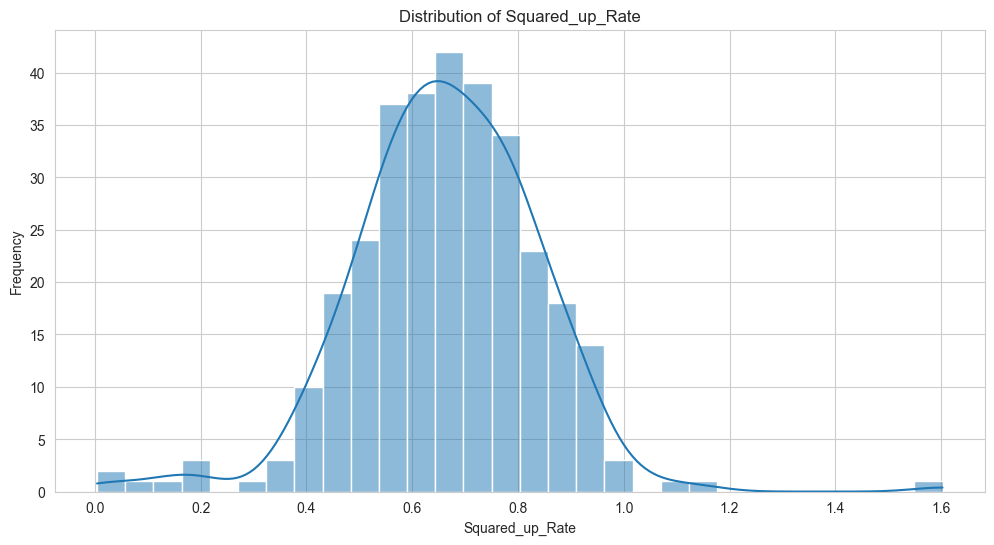

Min: 0.004219669469760425
Max: 1.6025641025641024
Mean: 0.6642768683268677
Std: 0.17505875636419277
Quantiles: 0.25    0.564467
0.50    0.664526
0.75    0.778432
Name: Squared_up_Rate, dtype: float64


In [16]:
# Visualize the distribution of Squared_up_Rate
plt.figure(figsize=(12, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of Squared_up_Rate')
plt.xlabel('Squared_up_Rate')
plt.ylabel('Frequency')
plt.show()

# Print basic statistics to help determine bins
print(f'Min: {y.min()}')
print(f'Max: {y.max()}')
print(f'Mean: {y.mean()}')
print(f'Std: {y.std()}')
print(f'Quantiles: {y.quantile([0.25, 0.5, 0.75])}')

### Classification model

In [17]:
# Create categories for Squared_up_Rate
bins = [0, 0.5, 0.6, 0.7, 0.8, np.inf]
labels = [0, 1, 2, 3, 4]
y_class = pd.cut(y, bins=bins, labels=labels, include_lowest=True)

# Split the dataset into train and test sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Train a classification model
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train_class, y_train_class)

# Predict and evaluate
y_pred_class = clf_model.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, average='weighted')
recall = recall_score(y_test_class, y_pred_class, average='weighted')
f1 = f1_score(y_test_class, y_pred_class, average='weighted')

print(f'Classification - Accuracy: {accuracy}')
print(f'Classification - Precision: {precision}')
print(f'Classification - Recall: {recall}')
print(f'Classification - F1 Score: {f1}')

Classification - Accuracy: 0.7936507936507936
Classification - Precision: 0.8183421516754851
Classification - Recall: 0.7936507936507936
Classification - F1 Score: 0.7966999931285645


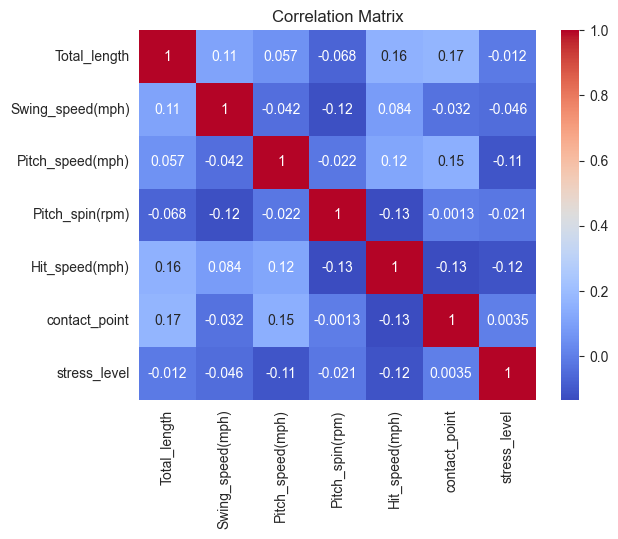

In [18]:
df_predict = df_predict.astype({
    'Total_length': float,
    'Swing_speed(mph)': float,
    'Pitch_speed(mph)': float,
    'Pitch_spin(rpm)': float,
    'Hit_speed(mph)': float,
    'Optimal_exit_velocity(mph)': float,
    'Squared_up_Rate': float,
    'contact_point': float,
    'stress_level': int
})

# Correlation matrix
correlation_matrix = df_predict[['Total_length', 'Swing_speed(mph)', 'Pitch_speed(mph)', 'Pitch_spin(rpm)', 'Hit_speed(mph)', 'contact_point', 'stress_level']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Independent variables
X = df_predict[['Total_length', 'Swing_speed(mph)', 'Pitch_speed(mph)', 'Pitch_spin(rpm)', 'Hit_speed(mph)', 'contact_point', 'stress_level']]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Dependent variable
y = df_predict['Squared_up_Rate']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Squared_up_Rate   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     95.50
Date:                Sun, 28 Jul 2024   Prob (F-statistic):           3.02e-73
Time:                        18:32:47   Log-Likelihood:                 284.55
No. Observations:                 315   AIC:                            -553.1
Df Residuals:                     307   BIC:                            -523.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7330      0.107  

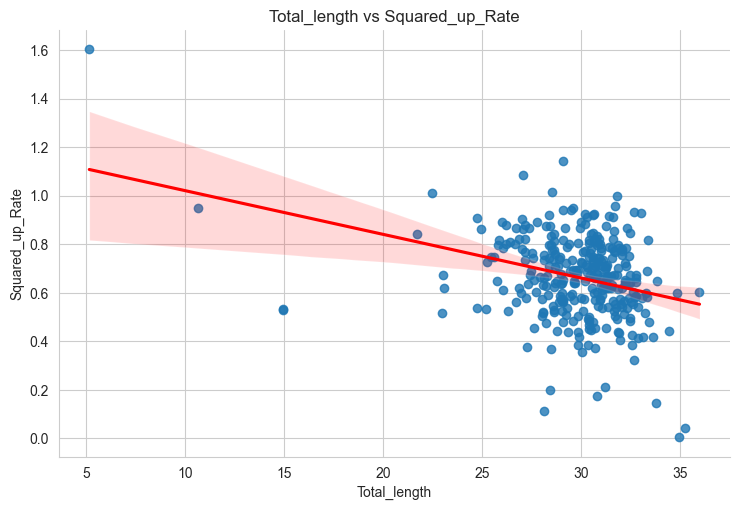

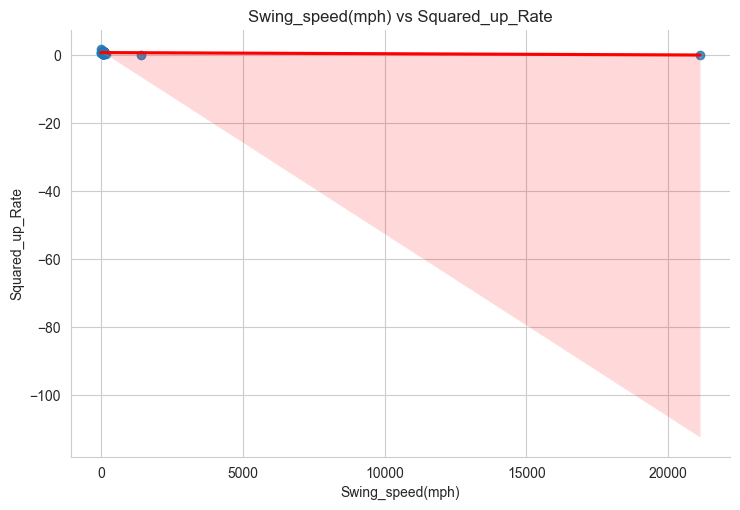

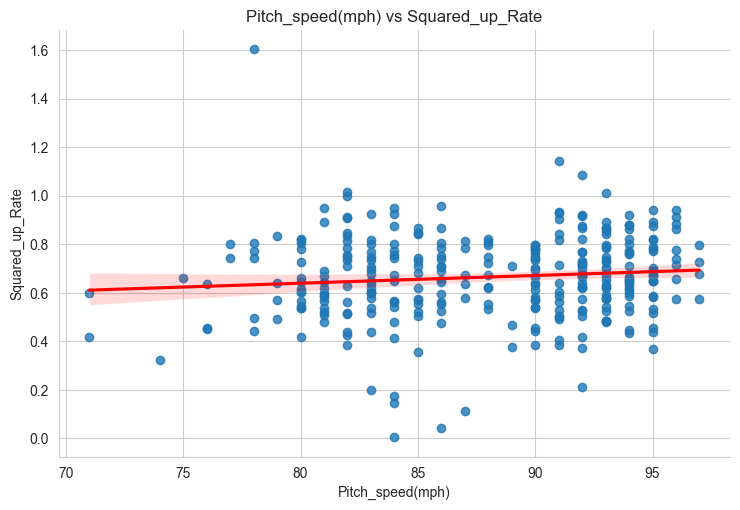

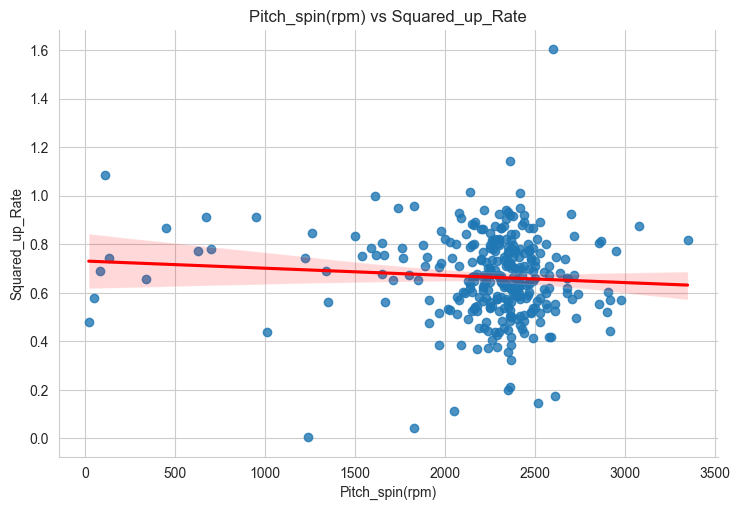

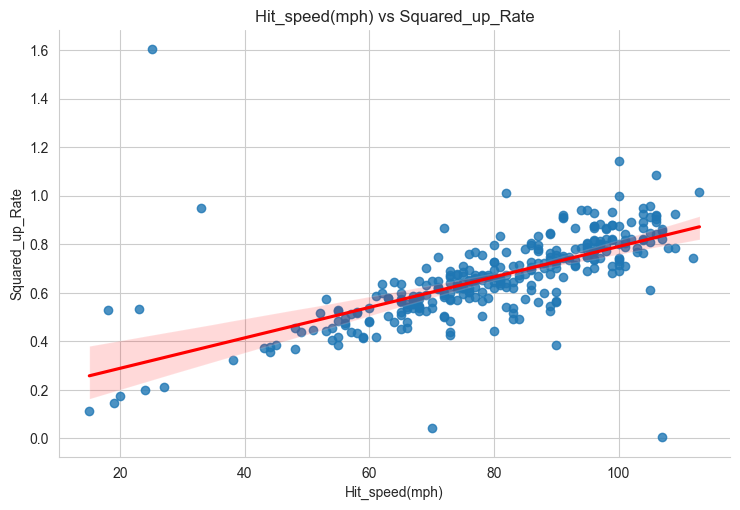

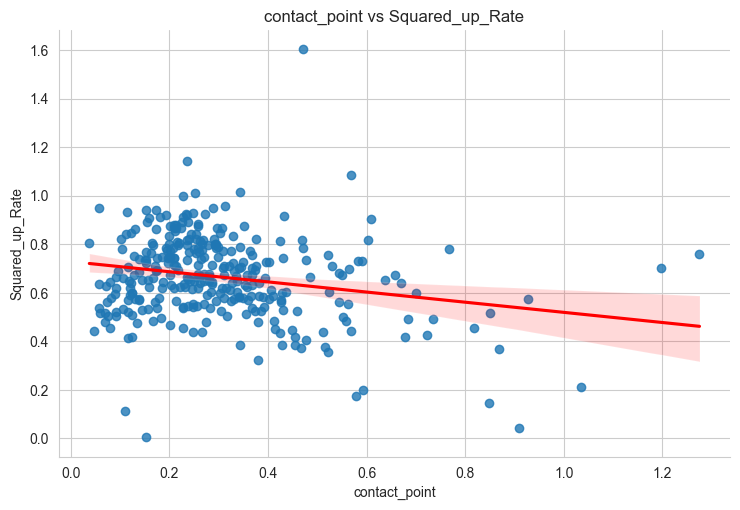

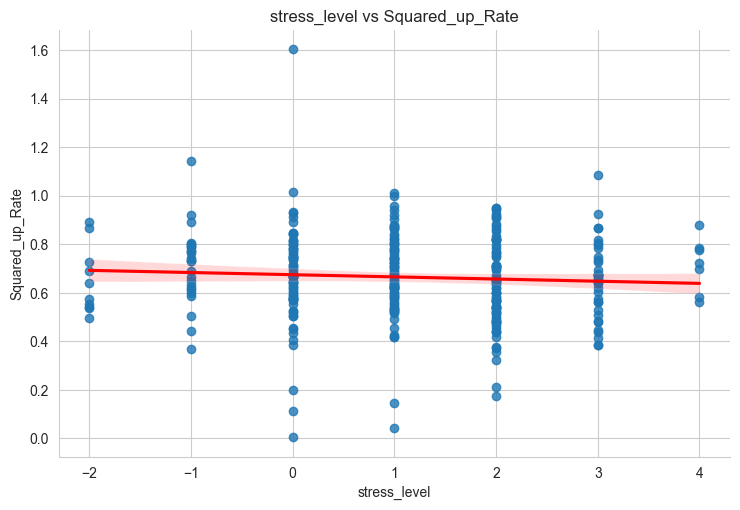

In [20]:
# Scatter plots with regression lines
variables = ['Total_length', 'Swing_speed(mph)', 'Pitch_speed(mph)', 'Pitch_spin(rpm)', 'Hit_speed(mph)', 'contact_point','stress_level']

for var in variables:
    sns.lmplot(x=var, y='Squared_up_Rate', data=df_predict, aspect=1.5, line_kws={'color': 'red'})
    plt.title(f'{var} vs Squared_up_Rate')
    plt.show()


Root Mean Squared Error: 0.16993944406127692


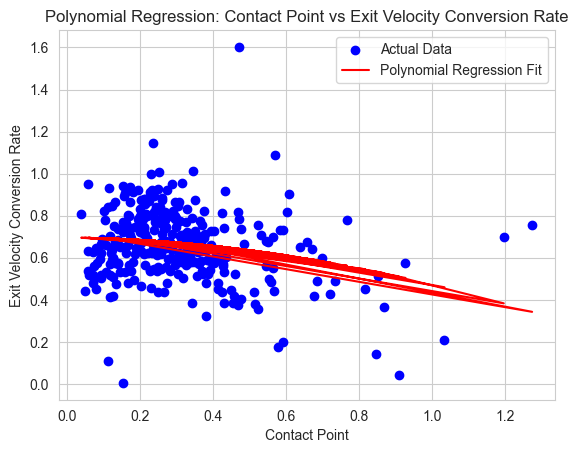

In [21]:
# Assuming df_predict is your DataFrame and 'contact_point' is one of the columns
# Extract the relevant columns
X = df_predict[['contact_point']].values
y = df_predict['Squared_up_Rate'].values  # Assuming 'exit_velocity_conversion_rate' is a column

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict using the model
y_pred = model.predict(X_poly)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# Plotting
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, y_pred, color='red', label='Polynomial Regression Fit')
plt.xlabel('Contact Point')
plt.ylabel('Exit Velocity Conversion Rate')
plt.title('Polynomial Regression: Contact Point vs Exit Velocity Conversion Rate')
plt.legend()
plt.show()


### Parameter explanation:
- Total Length: Longer trajectory lengths are associated with lower exit velocity conversion rates (Coefficient: -0.0225, P-value: 0.000).
- Swing Speed (mph): Swing speed might not have a direct impact on the exit velocity conversion rate in this model (Coefficient: -0.0001, P-value: 0.152).
- Pitch Speed (mph): Higher pitch speeds potentially increase the conversion rate, though the relationship is not statistically significant (Coefficient: 0.0013, P-value: 0.203).
- Pitch Spin (rpm): Pitch spin might not have a direct impact on the exit velocity conversion rate (Coefficient: -1.61e-05, P-value: 0.194).
- Hit Speed (mph): Higher hit speeds are strongly associated with higher exit velocity conversion rates (Coefficient: 0.0069, P-value: 0.000).
- Contact Point: Hitting the ball at suboptimal contact points reduces the exit velocity conversion rate (Coefficient: -0.0677, P-value: 0.033).
- Stress Level: Stress level might not have a direct impact on the exit velocity conversion rate in this model (Coefficient: 0.0004, P-value: 0.929).

### Contact Point analysis:
Regarding the Polynomial Regression graph depicting the relationship between Contact Point and Exit Velocity Conversion Rate, the data points are clustered together, indicating that most hits occur near the bat's head. This area is associated with a better exit velocity conversion rate. Specifically, the ideal contact point appears to be between 20% and 40% of the bat's length from the handle.

### Key Findings and Recommendations:
- **Trajectory Length:** Longer trajectory lengths are associated with lower exit velocity conversion rates. Contrary to our initial hypothesis that a longer trajectory would allow for more power buildup and result in higher speeds, the data suggests otherwise. A possible reason could be that excessive, non-contributory movements during longer swings negatively impact the hit.
- **Hit Speed:** Higher hit speeds significantly increase the exit velocity conversion rate, as expected.
- **Contact Point:** The ideal contact point appears to be between 20% and 40% of the bat's length from the handle.
- **Stress Level:** The analysis did not yield definitive conclusions about the impact of stress on exit velocity conversion, likely due to insufficient data and feature definitions. Also, stress effects can vary significantly among players—some may experience an increase in exit velocity under pressure, while others may see their performance decline.
    
### Next Steps:
- **Validate with Additional Data:**
  - Collect more data to validate the model and refine insights.
- **Explore Advanced Models:**
  - Investigate advanced machine learning models like neural networks.
  - Conduct hyperparameter tuning and feature engineering for better accuracy.